In [1]:
import time
import numpy as np 
import pandas as pd 

from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

C:\Users\drimamskom\Anaconda2\envs\opencv36\lib\site-packages\tqdm\autonotebook\__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
batch_size = 4
im_size = 64

In [3]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
im_size = 64
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = 'E:/klasifikasi/spermatozoa_data/seg_train', transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_loader)

In [4]:
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=64, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=64),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [5]:
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 4):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [6]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = 'E:/klasifikasi//spermatozoa_data/seg_train', transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = 'E:/klasifikasi//spermatozoa_data/seg_test', transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
#label klasifikasi
classes = train_data.classes
#encoder dan decoder konversi klasifikasi ke integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [7]:
print(classes)

['abnormal', 'normal']


In [8]:
import matplotlib.pyplot as plt
import random

def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


<Figure size 1400x1000 with 12 Axes>

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Linear(in_features = 1*1*1024, out_features = 1024)
        self.fcbn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(in_features = 1024, out_features = 2)       
        self.dropout_rate =0
    

    def forward(self,s):
        s = self.bn1(self.conv1(s))        # batch_size x 32 x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 32 x 32 x 32
        s = self.bn2(self.conv2(s))        # batch_size x 64 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 64 x 16 x 16
        s = self.bn3(self.conv3(s))        # batch_size x 128 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 128 x 8 x 8
        s = self.bn4(self.conv4(s))        # batch_size x 128 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 512 x 4 x 4
        s = self.bn5(self.conv5(s))        # batch_size x 128 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 512 x 4 x 4
        s = self.bn6(self.conv6(s))        # batch_size x 128 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))     # batch_size x 512 x 4 x 4
        #flatten the output tiap image
        s = s.view(-1, 1*1*1024)  # batch_size x 8*8*128

        #2 fully connected layers dg dropout
        s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
        p=self.dropout_rate, training=self.training)    # batch_size x 128
        s = self.fc2(s)                                 # batch_size x 2
        
        return F.log_softmax(s, dim=1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()

In [11]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [62]:
def train(model,dataloaders,criterion,num_epochs=1000,lr=0.00001,batch_size=4,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                #data = data.type(torch.cuda.FloatTensor)
                data = data.to(device)
                #target = target.type(torch.cuda.LongTensor)
                target = target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [63]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        #data = data.type(torch.cuda.FloatTensor)
        data = data.to(device)
        #target = target.type(torch.cuda.LongTensor)
        target = target.to(device)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [64]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [66]:
def train_model(model,dataloaders,criterion,num_epochs=1000,lr=0.00001,batch_size=4,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix')

Epoch: 0
train Epoch: 0  [0/610 (0%)]	Loss: 0.460747 	Acc: 0.750000
False
val Epoch: 0  [0/113 (0%)]	Loss: 0.511876 	Acc: 0.500000
Validation loss decreased (inf --> 0.427603).  Saving model ...
False
val Accuracy:  0.7083333333333334
Epoch: 1
train Epoch: 1  [0/610 (0%)]	Loss: 0.155738 	Acc: 1.000000
False
val Epoch: 1  [0/113 (0%)]	Loss: 1.048894 	Acc: 0.500000
EarlyStopping counter: 1 out of 3
False
val Accuracy:  0.5833333333333334
Epoch: 2
train Epoch: 2  [0/610 (0%)]	Loss: 0.367722 	Acc: 1.000000
False
val Epoch: 2  [0/113 (0%)]	Loss: 0.620935 	Acc: 0.500000
EarlyStopping counter: 2 out of 3
False
val Accuracy:  0.7083333333333334
Epoch: 3
train Epoch: 3  [0/610 (0%)]	Loss: 0.297446 	Acc: 1.000000
False
val Epoch: 3  [0/113 (0%)]	Loss: 0.927340 	Acc: 0.500000
EarlyStopping counter: 3 out of 3
True
Early stopping


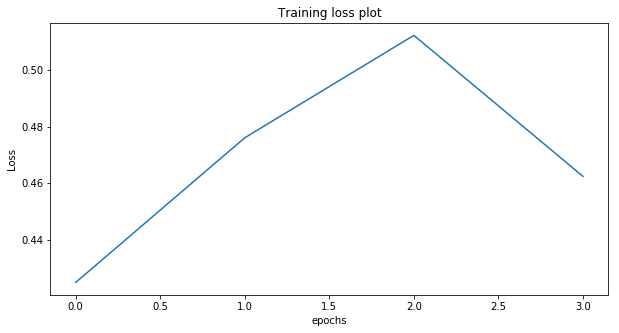

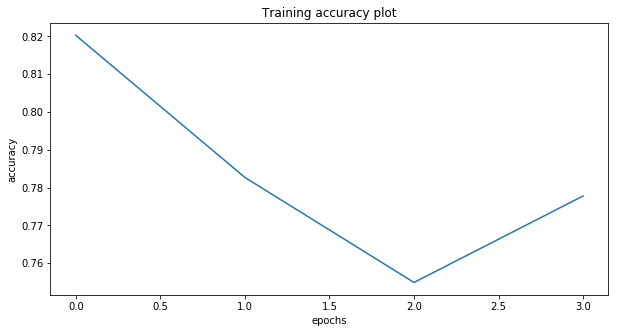

tensor(0.8696, dtype=torch.float64) 0.36767776780154393
Classes in order Actual and Predicted


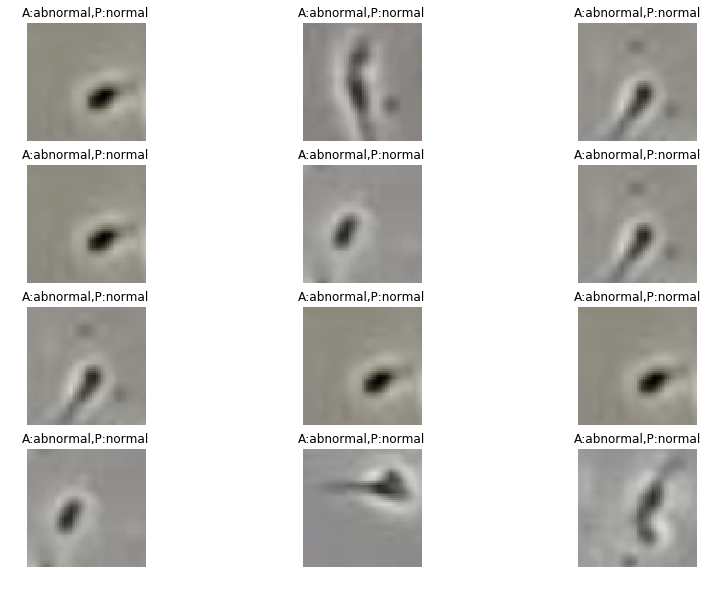

Precision: 88.53853853853855 Recall: 87.41496598639455, Accuracy: 87.91208791208791: ,f1_score: 87.6981688583016
Confusion matrix
[[34  8]
 [ 3 46]]


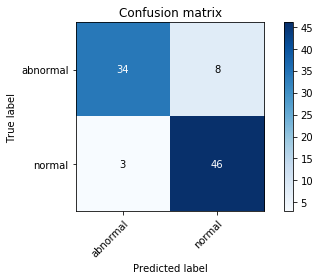

In [67]:
train_model(classifier,dataloaders,criterion,1000, patience = 3 , batch_size = batch_size , classes = classes)

In [68]:
from PIL import Image
import numpy as np
import cv2
def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    #model = torch.load('./model.h5')
    model.eval()
    if(isinstance(image,np.ndarray)):
        image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds

def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]
    
    size = len(a)
    #if(size>5):
        #a = np.flip(a[-5:])
    #else:
        #a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
        prediction.append(float(output[:,i]*100))
        clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")

def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()

In [69]:
image = cv2.imread('E:/klasifikasi/spermatozoa_data/1_0116.jpg')

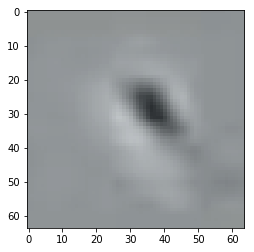

Class: abnormal , confidence: 45.92304992675781
Class: normal , confidence: 54.07694625854492


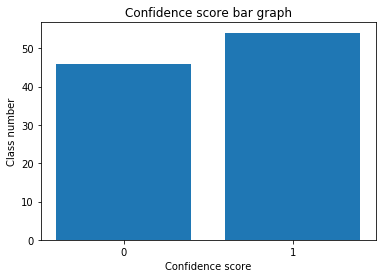

In [70]:
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

In [71]:
image = cv2.imread('E:/klasifikasi/spermatozoa_data/1_0030.jpg')

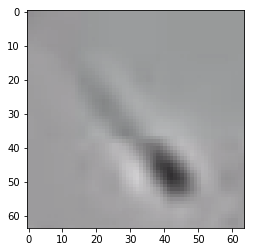

Class: abnormal , confidence: 17.95179557800293
Class: normal , confidence: 82.04821014404297


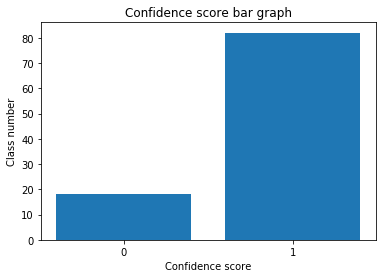

In [72]:
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)